<a href="https://colab.research.google.com/github/PhonxayMax/6_DL_-for_Vision_Systems_Mohamed-Elgendy/blob/main/CH4_chapter_4_improve_cifar_90_percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checked 25/05/2025
#import dependencies
import keras
from keras.models import Sequential
#from keras.utils import np_utils
# Import to_categorical directly from keras.utils
from keras.utils import to_categorical
# Update the import statement for ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Device Name: ", tf.test.gpu_device_name())

Num GPUs Available:  1
GPU Device Name:  /device:GPU:0


In [5]:
# download and split the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print("training data = ", x_train.shape)
print("testing data = ", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
training data =  (50000, 32, 32, 3)
testing data =  (10000, 32, 32, 3)


In [3]:
!nvidia-smi

Sun May 25 14:13:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             30W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# Normalize the data to speed up training
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# let's look at the normalized values of a sample image
x_train[0]

array([[[-0.9619245 , -0.91515917, -0.8995707 ],
        [-1.2113398 , -1.1645745 , -1.1801629 ],
        [-1.1022207 , -1.1333976 , -1.2113398 ],
        ...,
        [ 0.58133286,  0.17603296, -0.19809005],
        [ 0.48780212,  0.06691375, -0.2916208 ],
        [ 0.4254483 ,  0.05132529, -0.27603233]],

       [[-1.6322283 , -1.5698744 , -1.5698744 ],
        [-1.8816435 , -1.8816435 , -1.8816435 ],
        [-1.6010513 , -1.756936  , -1.8816435 ],
        ...,
        [ 0.03573683, -0.5098592 , -1.0242784 ],
        [-0.026617  , -0.5878015 , -1.1022207 ],
        [ 0.02014837, -0.52544767, -0.9931014 ]],

       [[-1.4919322 , -1.5075206 , -1.554286  ],
        [-1.6322283 , -1.7725244 , -1.8816435 ],
        [-1.117809  , -1.4607552 , -1.756936  ],
        ...,
        [-0.04220546, -0.57221305, -1.1022207 ],
        [-0.01102854, -0.57221305, -1.1022207 ],
        [-0.18250158, -0.7436861 , -1.2269284 ]],

       ...,

       [[ 1.3607558 ,  0.7683944 , -0.38515157],
        [ 1

In [7]:
# one-hot encode the labels in train and test datasets
# we use “to_categorical” function in keras

num_classes = 10
# Use to_categorical directly after importing it
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

# let's display one of the one-hot encoded labels
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [8]:
# build the model

# number of hidden units variable
# we are declaring this variable here and use it in our CONV layers to make it easier to update from one place
base_hidden_units = 32

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model = Sequential()

# CONV1
# notice that we defined the input_shape here because this is the first CONV layer.
# we don’t need to do that for the remaining layers
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 309,290 (1.18 MB)

 Trainable params: 308,394 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

In [9]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

In [10]:
# training
batch_size = 64
epochs=125

from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop # Import the RMSprop class

# Change the filepath extension from .hdf5 to .keras
checkpointer = ModelCheckpoint(filepath='model.125epochs.keras', verbose=1, save_best_only=True)

# you can try any of these optimizers by uncommenting the line
# optimizer = keras.optimizers.Adam(learning_learning_rate=0.0005,decay=1e-6) # Use the class name Adam

# Instantiate the RMSprop optimizer class
optimizer = RMSprop(learning_rate=0.0003, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# Use the fit method instead of fit_generator
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer],
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,verbose=2,
                validation_data=(x_test,y_test))

Epoch 1/125


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.37604, saving model to model.125epochs.keras
781/781 - 49s - 63ms/step - accuracy: 0.3720 - loss: 2.1357 - val_accuracy: 0.5312 - val_loss: 1.3760
Epoch 2/125


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.37604 to 1.32420, saving model to model.125epochs.keras
781/781 - 1s - 1ms/step - accuracy: 0.4375 - loss: 1.7495 - val_accuracy: 0.5488 - val_loss: 1.3242
Epoch 3/125

Epoch 3: val_loss improved from 1.32420 to 1.19752, saving model to model.125epochs.keras
781/781 - 64s - 82ms/step - accuracy: 0.5131 - loss: 1.4893 - val_accuracy: 0.6068 - val_loss: 1.1975
Epoch 4/125

Epoch 4: val_loss improved from 1.19752 to 1.14886, saving model to model.125epochs.keras
781/781 - 1s - 2ms/step - accuracy: 0.5312 - loss: 1.5121 - val_accuracy: 0.6241 - val_loss: 1.1489
Epoch 5/125

Epoch 5: val_loss did not improve from 1.14886
781/781 - 40s - 51ms/step - accuracy: 0.5869 - loss: 1.2428 - val_accuracy: 0.6427 - val_loss: 1.1543
Epoch 6/125

Epoch 6: val_loss did not improve from 1.14886
781/781 - 1s - 1ms/step - accuracy: 0.5781 - loss: 1.0204 - val_accuracy: 0.6296 - val_loss: 1.1983
Epoch 7/125

Epoch 7: val_loss improved from 1.14886 to 0.93719, saving model t

In [ ]:
# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

 9728/10000 [============================>.] - ETA: 0s
Test result: 89.590 loss: 0.403


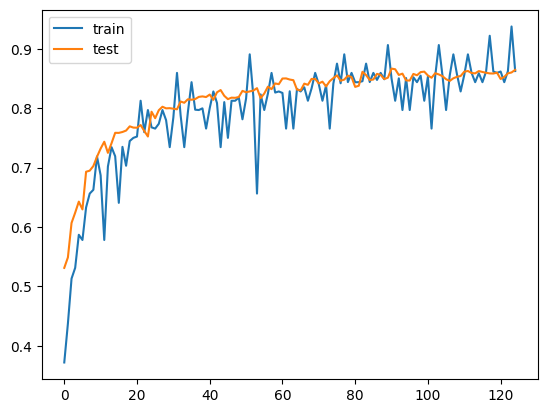

In [13]:
# plot learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()